# Reinforcement Learning hyperparameter tuning with hyperoptax and rejax

In [1]:
import time

import jax
import matplotlib.pyplot as plt
import numpy as np
import rejax

from hyperoptax.grid import GridSearch
from hyperoptax.spaces import LinearSpace, LogSpace

rng = jax.random.PRNGKey(42)

In [2]:
# make an RL agent
ppo = rejax.algos.PPO
jit_train = jax.jit(ppo.train)
timesteps = 100_000
agent = ppo.create(env="CartPole-v1", total_timesteps=timesteps)
ts, evaluation = jit_train(agent, rng)

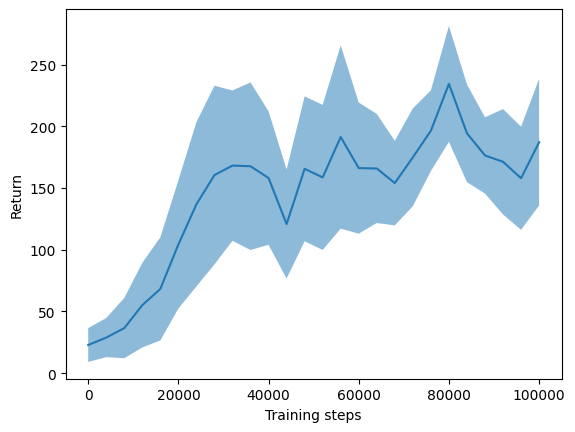

In [3]:
def plot_eval(evaluation, label="", fig=None, ax=None):
    if fig is None:
        fig, ax = plt.subplots()
    xaxis = np.linspace(0, timesteps, len(evaluation.mean(axis=1)))
    ax.plot(xaxis, evaluation.mean(axis=1), label=label)
    ax.fill_between(
        xaxis,
        evaluation.mean(axis=1) - evaluation.std(axis=1),
        evaluation.mean(axis=1) + evaluation.std(axis=1),
        alpha=0.5,
    )
    ax.set_xlabel("Training steps")
    ax.set_ylabel("Return")

    return fig, ax


fig, ax = plot_eval(evaluation[1], label="Initial")

In [4]:
# Optimize RL hyperparameters
n_samples_per_hparam = 10
hparams = {
    "learning_rate": LogSpace(1e-5, 1e-1, n_samples_per_hparam),
    "max_grad_norm": LinearSpace(0.01, 10, n_samples_per_hparam),
    "ent_coef": LogSpace(1e-4, 1e1, n_samples_per_hparam),
}


def wrapper(learning_rate, max_grad_norm, ent_coef):
    agent = ppo.create(
        env="CartPole-v1",
        learning_rate=learning_rate,
        max_grad_norm=max_grad_norm,
        ent_coef=ent_coef,
    )
    ts, evaluation = jit_train(agent, rng)
    return evaluation[1].mean(axis=1)[-1]


search = GridSearch(hparams, wrapper, random_search=True)

start = time.time()
result = search.optimize(20, n_vmap=2, jit=True).flatten()
print(f"Time taken: {time.time() - start:.2f} seconds")

print(
    "Best hyperparameters:\n"
    f"Learning rate: {result.tolist()[0]:4f}\n"
    f"Max grad norm: {result.tolist()[1]:4f}\n"
    f"Ent coef: {result.tolist()[2]:4f}"
)

Time taken: 44.96 seconds
Best hyperparameters:
Learning rate: 0.012915
Max grad norm: 8.890000
Ent coef: 0.001292


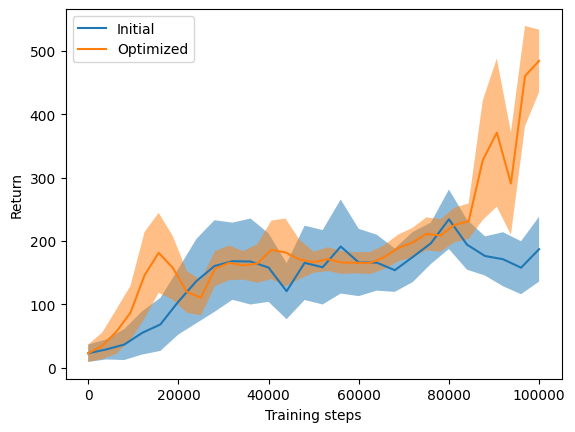

In [5]:
# Train and evaluate the tuned RL agent
agent = ppo.create(
    env="CartPole-v1",
    learning_rate=result[0],
    max_grad_norm=result[1],
    ent_coef=result[2],
)
ts, evaluation = jit_train(agent, rng)

fig, ax = plot_eval(evaluation[1], label="Optimized", fig=fig, ax=ax)
ax.legend()
fig